In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
from pylab import rcParams
import seaborn as sns
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
sns.set(style="darkgrid")
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import nltk
import re
import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string
nltk.download('stopwords')
nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)

from nltk.stem.snowball import SnowballStemmer
stemmer_snowball = SnowballStemmer('english')

from nltk.stem.porter import PorterStemmer
stemmer_porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shwetasharma1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shwetasharma1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("./users_essay")

In [3]:
rf_data = df[["age", "drinks", "education", "ethnicity", "orientation", "sex", "smokes", "religion", "drugs", "essay"]]
# rf_data = users_no_na[["drinks","smokes", "drugs"]]

rf_data["drugs"] = rf_data["drugs"].replace(["never","sometimes", "often"], [0,1,1])

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## PreProcessing for NLP

In [5]:
def make_buckets(rf_data):
    
    # putting different ethnicities in wider buckets
    
    rf_data["ethnicity"] = rf_data["ethnicity"].fillna("other")
    rf_data.loc[rf_data['ethnicity'].str.contains('asian',), 'ethnicity'] = 'asian'
    rf_data.loc[rf_data['ethnicity'].str.contains('indian'), 'ethnicity'] = 'asian'
    rf_data.loc[rf_data["ethnicity"].str.contains('hispanic / latin'), 'ethnicity'] = 'hispanic/latin'
    rf_data.loc[rf_data["ethnicity"].str.contains('american'), 'ethnicity'] = 'american'
    rf_data.loc[rf_data["ethnicity"].str.contains('native american'), 'ethnicity'] = 'american'
    rf_data.loc[rf_data['ethnicity'].str.contains('black'), 'ethnicity'] = 'american'
    rf_data.loc[rf_data["ethnicity"].str.contains('pacific islander'), 'ethnicity'] = 'pacific islander'
    rf_data.loc[rf_data["ethnicity"].str.contains('white'), 'ethnicity'] = 'american'
    rf_data.loc[rf_data["ethnicity"].str.contains('middle eastern,'), 'ethnicity'] = 'middle eastern'
    
    # putting different religions in wider buckets

    rf_data["religion"] = rf_data["religion"].fillna("other")
    rf_data.loc[rf_data['religion'].str.contains('agnosticism'), 'religion'] = 'agnosticism'
    rf_data.loc[rf_data['religion'].str.contains('atheism'), 'religion'] = 'atheism'
    rf_data.loc[rf_data['religion'].str.contains('catholicism'), 'religion'] = 'catholicism'
    rf_data.loc[rf_data['religion'].str.contains('buddhism'), 'religion'] = 'buddhism'
    rf_data.loc[rf_data['religion'].str.contains('other'), 'religion'] = 'other'
    rf_data.loc[rf_data['religion'].str.contains('hinduism'), 'religion'] = 'hinduism'
    rf_data.loc[rf_data['religion'].str.contains('islam'), 'religion'] = 'islam'
    rf_data.loc[rf_data['religion'].str.contains('judaism'), 'religion'] = 'judaism'
    rf_data.loc[rf_data['religion'].str.contains('christianity'), 'religion'] = 'christianity'
    
    # putting different education classes in wider buckets


    rf_data["education"] = rf_data["education"].fillna('in college/university')
    rf_data.loc[rf_data['education'].str.contains("graduated"), 'education'] = 'graduated'
    rf_data.loc[rf_data['education'].str.contains("working"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("two-year college"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("masters program"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("law school"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("space camp"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("ph.d program"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("med school"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("college/university"), 'education'] = 'in college/university'
    rf_data.loc[rf_data['education'].str.contains("dropped out"), 'education'] = 'dropped out'
    
    #treating nans
    rf_data["drinks"] = rf_data["drinks"].fillna("not at all")
    rf_data["smokes"] = rf_data["smokes"].fillna("no")

In [6]:
make_buckets(rf_data)

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [7]:
cleaned_rf_data = rf_data[["age", "drinks", "education", "ethnicity", "orientation", "sex", "smokes", "religion", "drugs"]]
cleaned_rf_data_dummified = pd.get_dummies(cleaned_rf_data)

In [8]:
cleaned_rf_data_dummified = pd.concat([cleaned_rf_data_dummified, rf_data["essay"]], axis = 1)

In [9]:
X_nlp = cleaned_rf_data_dummified.loc[:,cleaned_rf_data_dummified.columns != "drugs"]


y_nlp = cleaned_rf_data_dummified.loc[:,cleaned_rf_data_dummified.columns == "drugs"]

In [16]:
X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(X_nlp, y_nlp, test_size = .10, random_state=1)

In [17]:
# X_nlp_test = X_nlp_test.drop("essay", axis = 1)

## TFIDF vectorization

In [18]:
tfidf = TfidfVectorizer(max_features = 5000)

In [19]:
tfidf_matrix_train = tfidf.fit_transform(X_nlp_train.essay.values.astype('U'))

In [20]:
tfidf_matrix_test =  tfidf.transform(X_nlp_test.essay.values.astype('U'))

In [21]:
data_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf.get_feature_names())
data_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf.get_feature_names())

In [22]:
data_train.reset_index(drop=True, inplace=True)
X_nlp_train.reset_index(drop=True, inplace=True)
df_nlp_train = pd.concat([data_train, X_nlp_train], axis=1)

data_test.reset_index(drop=True, inplace=True)
X_nlp_test.reset_index(drop=True, inplace=True)
df_nlp_test = pd.concat([data_test, X_nlp_test], axis=1)

In [24]:
df_nlp_test = df_nlp_test.drop("essay", axis=1)
df_nlp_train = df_nlp_train.drop("essay", axis=1);

In [25]:
df_nlp_train.reset_index(drop=True, inplace=True)
y_nlp_train.reset_index(drop=True, inplace=True)

new_train = pd.concat([df_nlp_train, y_nlp_train], axis = 1)




df_nlp_test.reset_index(drop=True, inplace=True)
y_nlp_test.reset_index(drop=True, inplace=True)
new_test = pd.concat([df_nlp_test, y_nlp_test], axis = 1)

In [26]:
untouched_x = new_test.loc[:, new_test.columns != "drugs"]
untouched_y = new_test.loc[:, new_test.columns == "drugs"]

## OVERSAMPLING

In [27]:
# Class count
count_class_0, count_class_1 = new_train["drugs"].value_counts()

rf_class_0 = new_train[new_train['drugs'] == 0]
rf_class_1 = new_train[new_train['drugs'] == 1]

Random over-sampling:
1    33922
0    33922
Name: drugs, dtype: int64


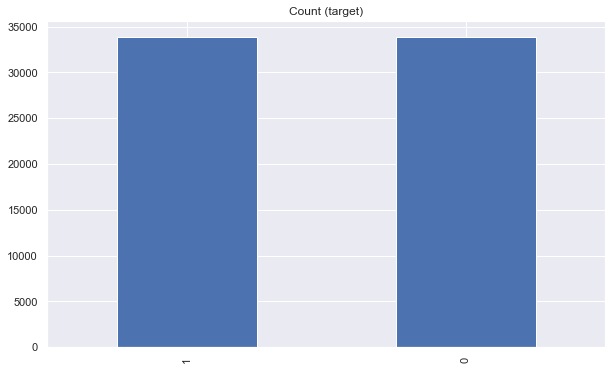

In [28]:
rf_class_1_over = rf_class_1.sample(count_class_0, replace=True)
rf_test_over = pd.concat([rf_class_0, rf_class_1_over], axis=0)

print('Random over-sampling:')
print(rf_test_over["drugs"].value_counts())

rf_test_over["drugs"].value_counts().plot(kind='bar', title='Count (target)');

In [29]:
X_nlp_over = rf_test_over.loc[:, rf_test_over.columns != "drugs"]
y_nlp_over = rf_test_over.loc[:, rf_test_over.columns =="drugs"]
X_nlp_over_train, X_nlp_over_test, y_nlp_over_train, y_nlp_over_test = train_test_split(X_nlp_over, y_nlp_over, test_size=0.10, random_state=1)
# model = RandomForestClassifier()
# model.fit(X_rf_over_train, y_rf_over_train)
# y_rf_over_preds = model.predict(X_rf_over_test)

In [30]:
def run_model(estimator, X, y):
    kf = KFold(n_splits=5, shuffle=True)
    
    acc = []
    f1 = []
    for train_idx, test_idx in kf.split(X):
        X_train = X[train_idx]
        y_train = y[train_idx]
         
        
        X_test = X[test_idx]
        y_test = y[test_idx]

        # data prep
        
        estimator.fit(X_train, y_train)
        y_preds = estimator.predict(X_test)
        acc.append(accuracy_score(y_test, y_preds))
        f1.append(f1_score(y_test, y_preds))
    
    generate_model_report(y_test, y_preds)
        
    plt.plot(range(0, 5), f1, label=estimator.__class__.__name__)
    
def generate_model_report(y_actual, y_predicted):
    print('Accuracy: %.3f' % accuracy_score(y_actual, y_predicted))
    print('Precision: %.3f' % precision_score(y_actual, y_predicted))
    print( 'Recall: %.3f' % recall_score(y_actual, y_predicted))
    print('F1 score: %.3f' % f1_score(y_actual, y_predicted))

In [31]:
model = RandomForestClassifier()
model.fit(X_nlp_over_train.values, y_nlp_over_train["drugs"].values)


RandomForestClassifier()

In [32]:
y_nlp_over_preds = model.predict(X_nlp_over_test)

In [33]:
generate_model_report(y_nlp_over_test, y_nlp_over_preds)

Accuracy: 0.978
Precision: 0.968
Recall: 0.989
F1 score: 0.978


In [34]:
y_nlp_final_preds = model.predict(untouched_x)
generate_model_report(untouched_y, y_nlp_final_preds)

Accuracy: 0.844
Precision: 0.599
Recall: 0.265
F1 score: 0.367


Accuracy: 0.965
Precision: 0.952
Recall: 0.979
F1 score: 0.965


KeyboardInterrupt: 

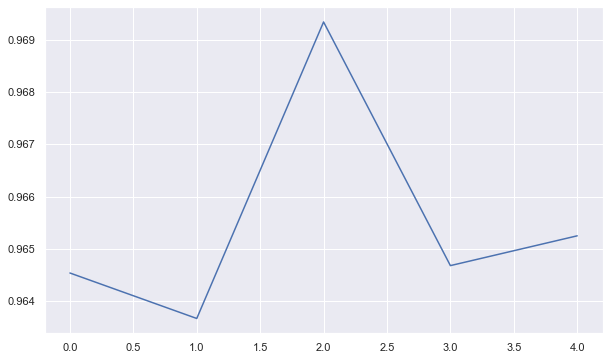

In [35]:
estimators = [RandomForestClassifier(), GradientBoostingClassifier()]
for estimator in estimators:
    run_model(estimator, X_nlp_over_train.values, y_nlp_over_train["drugs"].values)
    
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('# of Folds', fontsize=20)
plt.legend()

In [ ]:
y_nlp_final_preds = model.predict(untouched_x)
generate_model_report(untouched_y, y_nlp_final_preds)

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

def display_default_and_gsearch_model_results(model_default, model_gridsearch, 
                                              X_test, y_test):
    '''
        Parameters: model_default: fit model using initial parameters
                    model_gridsearch: fit model using parameters from gridsearch
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Return: None, but prints out mse and r2 for the default and model with
                gridsearched parameters
    '''
    name = model_default.__class__.__name__.replace('Classifier', '') # for printing
    y_test_pred = model_gridsearch.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    print("Results for {0}".format(name))
    print("Gridsearched model acc: {:0.3f}".format(acc))
    y_test_pred = model_default.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    print("     Default model acc: {:0.3f}".format(acc))
    
    
    
def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='accuracy')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best

In [ ]:
rf = RandomForestClassifier()

In [ ]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}

rf_best_params, rf_best_model = gridsearch_with_output(RandomForestClassifier(), 
                                                       random_forest_grid, 
                                                       X_nlp_over_train, y_nlp_over_train)

In [ ]:
print("\nComparing model with gridsearch params to initial model on Test set.")
rf.fit(X_nlp_over_train, y_nlp_over_train)
display_default_and_gsearch_model_results(rf, rf_best_model, X_nlp_over_test, y_nlp_over_test)

In [ ]:
gdbr = GradientBoostingClassifier()

In [ ]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [500],
                          'random_state': [1]}
gdbr_best_params, gdbr_best_model = gridsearch_with_output(GradientBoostingClassifier(), 
                                                           gradient_boosting_grid, 
                                                            X_nlp_over_train, y_nlp_over_train)

print("\nComparing model with gridsearch params to initial model on Test set.")
gdbr.fit(X_train, y_train)
display_default_and_gsearch_model_results(gdbr, gdbr_best_model,  X_nlp_over_test, y_nlp_over_test)
